Loading data...
Preprocessing data...
Features: 561, Classes: 6
Class mapping: {'LAYING': np.int64(0), 'SITTING': np.int64(1), 'STANDING': np.int64(2), 'WALKING': np.int64(3), 'WALKING_DOWNSTAIRS': np.int64(4), 'WALKING_UPSTAIRS': np.int64(5)}

Training Random Forest...

Training SVM...

Training Deep Learning Model...


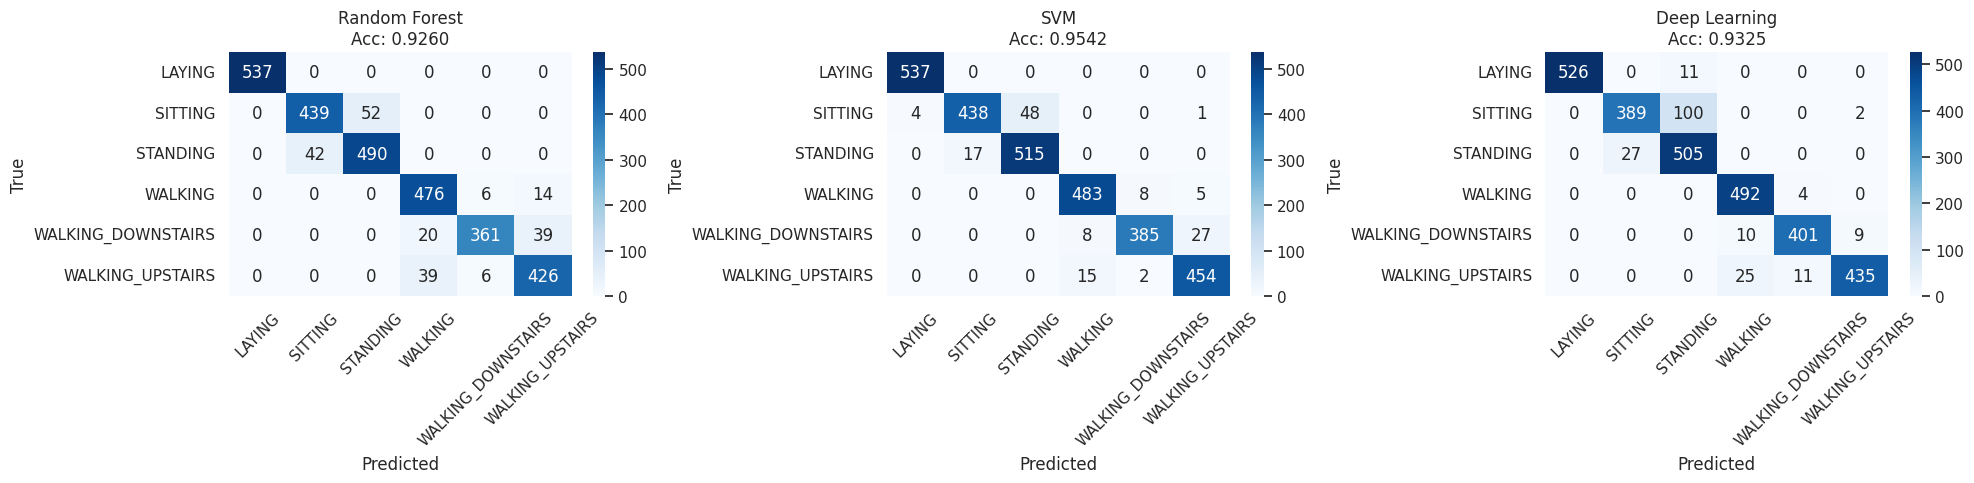


=== Model Comparison Results ===
           Model  Accuracy  F1 Score  Precision
0  Random Forest  0.926026  0.925944   0.927302
1            SVM  0.954191  0.954022   0.954949
2  Deep Learning  0.932474  0.932313   0.936399

Best Performing Model: SVM with Accuracy: 0.9542


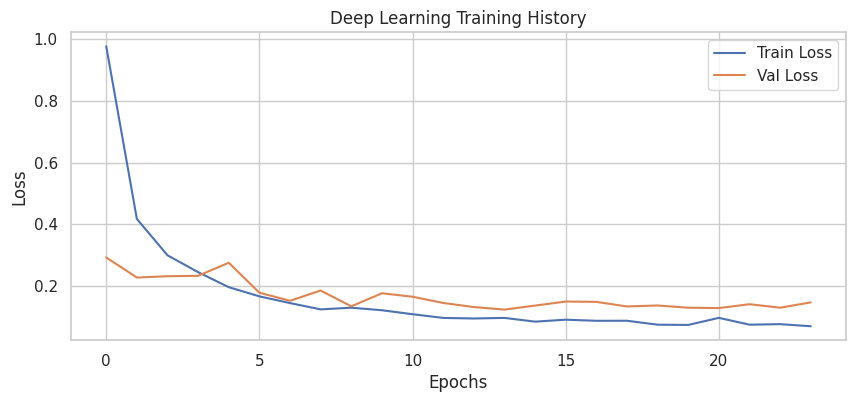

In [ ]:
# ==========================================
# 1. SETUP AND IMPORTS
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Set plot style
sns.set(style="whitegrid")

# ==========================================
# 2. LOAD DATA
# ==========================================
try:
    test_df = pd.read_csv('/content/drive/MyDrive/test.csv')
    train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
except FileNotFoundError:
    print("Error: Please make sure 'train.csv' and 'test.csv' are uploaded.")

# ==========================================
# 3. PREPROCESSING
# ==========================================
def preprocess_data(df, is_train=True, label_encoder=None):
    # Drop 'subject' as it's an identifier, not a feature for classification. It makes the model learn more about the names rather than the activities.
    # Drop 'Activity' as it's the output and we do not want the model to see the answer and guess it itself.
    if 'subject' in df.columns:
        X = df.drop(['subject', 'Activity'], axis=1)
    else:
        X = df.drop(['Activity'], axis=1)

    y = df['Activity']

    # Encode target labels (Text -> Numbers)
    if is_train:
        le = LabelEncoder()
        y_enc = le.fit_transform(y)
        return X, y_enc, le
    else:
        y_enc = label_encoder.transform(y)
        return X, y_enc, None

print("Preprocessing data...")
X_train_raw, y_train, le = preprocess_data(train_df, is_train=True)
X_test_raw, y_test, _ = preprocess_data(test_df, is_train=False, label_encoder=le)

# Scale Features (Critical for SVM and Deep Learning)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

num_classes = len(np.unique(y_train))
input_shape = X_train.shape[1]

print(f"Features: {input_shape}, Classes: {num_classes}")
print(f"Class mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# ==========================================
# 4. MODEL DEFINITIONS
# ==========================================

# --- A. Classical: Random Forest ---
def train_rf(X_train, y_train):
    print("\nTraining Random Forest...")
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    return rf

# --- B. Classical: SVM ---
def train_svm(X_train, y_train):
    print("\nTraining SVM...")
    # Using RBF kernel which is generally best for HAR
    svm = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
    svm.fit(X_train, y_train)
    return svm

# --- C. Deep Learning: Neural Network (MLP) ---
def train_dl(X_train, y_train, input_shape, num_classes):
    print("\nTraining Deep Learning Model...")

    model = keras.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5), # Regularization to prevent overfitting
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Early stopping to prevent overfitting
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0
    )
    return model, history

# ==========================================
# 5. TRAINING AND EVALUATION
# ==========================================
results = {}

# 1. Random Forest
rf_model = train_rf(X_train, y_train)
rf_pred = rf_model.predict(X_test)
results['Random Forest'] = rf_pred

# 2. SVM
svm_model = train_svm(X_train, y_train)
svm_pred = svm_model.predict(X_test)
results['SVM'] = svm_pred

# 3. Deep Learning
dl_model, dl_history = train_dl(X_train, y_train, input_shape, num_classes)
dl_pred_probs = dl_model.predict(X_test, verbose=0)
dl_pred = np.argmax(dl_pred_probs, axis=1)
results['Deep Learning'] = dl_pred

# ==========================================
# 6. COMPARISON & VISUALIZATION
# ==========================================
metrics_data = []

plt.figure(figsize=(20, 5))

for i, (name, y_pred) in enumerate(results.items()):
    # Calculate Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    prec = precision_score(y_test, y_pred, average='weighted')

    metrics_data.append([name, acc, f1, prec])

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.subplot(1, 3, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{name}\nAcc: {acc:.4f}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Display Comparison Table
metrics_df = pd.DataFrame(metrics_data, columns=['Model', 'Accuracy', 'F1 Score', 'Precision'])
print("\n=== Model Comparison Results ===")
print(metrics_df)

# Determine the winner
best_model = metrics_df.loc[metrics_df['Accuracy'].idxmax()]
print(f"\nBest Performing Model: {best_model['Model']} with Accuracy: {best_model['Accuracy']:.4f}")

# Plot Training History for DL
plt.figure(figsize=(10, 4))
plt.plot(dl_history.history['loss'], label='Train Loss')
plt.plot(dl_history.history['val_loss'], label='Val Loss')
plt.title('Deep Learning Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()